In [3]:
# from unet_model import *
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from datetime import datetime
import glob
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
import shutil

from unet_model import *
from data_prep import *

# from numba import cuda

# %load_ext tensorboard

tf.__version__

'2.3.0'

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_logical_devices('GPU')
# tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

# Model

## Load Model

In [173]:
model_name = "20200831-032132_lr001/"
model = keras.models.load_model("saved_models/"+model_name)

## Declare, Compile, and Train UNet Model

In [3]:
# To train only one model at a time. To train multiple in a row, run train_mult_models script

# # learning_rate = 0.001
# learning_rates = [0.001, 0.0003, 0.0001]

# for learning_rate in learning_rates:
#     print("Training with learning rate: " + str(learning_rate))
# #     logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr" + str(learning_rate).split('.')[1]
# #     tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

#     model = unet_model((512,512,1))

#     # model.summary()

#     opt = keras.optimizers.Adam(learning_rate=learning_rate) # default is 0.001
#     model.compile(optimizer = opt, loss="binary_crossentropy", metrics=["accuracy"])

#     # create_generators
#     seed = 1
#     batchsize = 2

#     train_generator, val_generator = create_generators(seed=seed, batchsize=batchsize)
#     # train_generator, val_generator = create_generators("tranformed_val", seed=seed, batchsize=batchsize)

#     epochs = 2

#     # history = model.fit(x=X_train, y=Y_train, epochs=30, batch_size=1)

#     history = model.fit(
#         train_generator,
#         steps_per_epoch=24/batchsize, # TODO: fix this #TODO: check that mult by 10 reduces number of epochs to get to same thing 
#         validation_data=val_generator,
#         validation_steps=6/batchsize, # TODO: fix this
#         epochs=epochs,
#         verbose=1
# #         callbacks=[tensorboard_callback]
#     )
    
#     del model
# #     model=None
#     tf.keras.backend.clear_session()
#     tf.compat.v1.reset_default_graph()
# #     device = cuda.get_current_device()
# #     device.reset()
# #     reset_seeds()

    
# #     cuda.select_device(0)
# #     cuda.close()
    
    
#     print()

# Model Analysis

## Import all training image

In [156]:
# img_path = "../unet/data/membrane/train/image/0.png"

# img = image.load_img(img_path)
# imshow(img)

# x = image.img_to_array(img)
# print(x[0,0])
# print(x.shape)
# print(x[0].shape)
# print(x[0][9])
# # history = model.fit()

# load in images

assert (len(glob.glob("../unet/data/membrane/train/image/*.png")) == len(glob.glob("../unet/data/membrane/train/label/*.png")))
X_train_orig = []
Y_train_orig = []
for i in range(len(glob.glob("../unet/data/membrane/train/image/*.png"))):
    img_path = "../unet/data/membrane/train/image/{}.png".format(i)
    img = image.load_img(img_path)
    x = image.img_to_array(img)[:,:,0] # since grayscale, only care about one of 3 channels
    x = np.expand_dims(x, axis=-1)
    X_train_orig.append(x)
    
    img_path = "../unet/data/membrane/train/label/{}.png".format(i)
    img = image.load_img(img_path)
    y = image.img_to_array(img)[:,:,0]
    y = np.expand_dims(y, axis=-1)
    Y_train_orig.append(y)
    
X_train_orig = np.array(X_train_orig)
print (X_train_orig.shape)
Y_train_orig = np.array(Y_train_orig)
print(Y_train_orig.shape)

X_train = X_train_orig / 255
Y_train = Y_train_orig / 255
print(Y_train_orig[0,0,0,0])
print(Y_train[0,0,0,0])

X_test_orig = []

for i in range(len(glob.glob("../unet/data/membrane/test/*predict.png"))): # TODO: find better way to iterate over
    img_path = "../unet/data/membrane/test/{}.png".format(i)
    img = image.load_img(img_path)
    x = image.img_to_array(img)[:,:,0]
    x = np.expand_dims(x, axis=-1)
    X_test_orig.append(x)
    
X_test_orig = np.array(X_test_orig)
print(X_test_orig.shape)

X_test = X_test_orig / 255


print (X_train.shape)
print(Y_train.shape)

(30, 512, 512, 1)
(30, 512, 512, 1)
255.0
1.0
(30, 512, 512, 1)
(30, 512, 512, 1)
(30, 512, 512, 1)


# Visualize Predictions

### Training Set

In [7]:
predicted = model.predict(X_train[0:1])

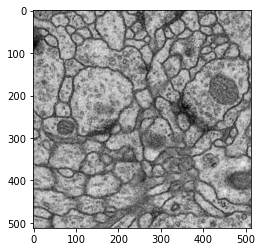

In [8]:
imshow(X_train[0,:,:,0], cmap='gray', vmin=0, vmax=1)
# X_train

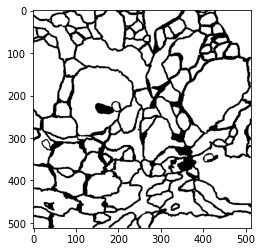

In [9]:
# predicted > 0.5
imshow(Y_train[0,:,:,0], cmap='gray', vmin=0, vmax=1)

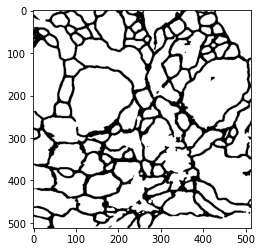

In [10]:
imshow((predicted[0,:,:,0]>0.5).astype(int), cmap='gray', vmin=0, vmax=1)
# imshow(predicted[0,:,:,0], cmap="gray", vmin=0, vmax=1)

### Test Set

Save predicted segmentations

In [178]:
save_to = "data/test_set/predictions/"+model_name
os.makedirs(save_to)

for f in os.listdir("data/test_set/images/"):
    img_path = "data/test_set/images/" + f
    img = image.load_img(img_path)
    x = image.img_to_array(img)[:,:,0:1]
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    
    predicted = model.predict(x)    
    rescaled = ((predicted[0,:,:,0]>0.5) * 255).astype(np.uint8)
    im = Image.fromarray(rescaled)
    im.save(save_to+f)

In [93]:
# imshow([[0,1],[1,0]], cmap="gray", vmin=0, vmax=1)

## Analyze Loss and Accuracy

This only works when you run a model in this notebook.<br>
Doesn't make sense to run this sense one can use TensorBoard (see logs directory)

In [179]:
# print(history.history.keys())
# # print(history.history['loss'])
# loss = history.history['loss']
# acc = history.history['accuracy']

# val_loss = history.history['val_loss']
# val_acc = history.history['val_accuracy']

In [181]:
# fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2,2)

# fig.set_size_inches(15, 10)

# ax11.plot(range(1,epochs+1), loss)
# ax11.plot(range(1,epochs+1), val_loss)
# ax11.set_title('Loss')
# ax11.set_xlabel("Epoch")
# ax11.set_ylabel("Loss");
# ax11.set_ylim(0,1)
# ax11.legend(['acc', 'val_acc'])

# ax12.plot(range(1,epochs+1), acc)
# ax12.plot(range(1,epochs+1), val_acc)
# ax12.set_title('Accuracy')
# ax12.set_xlabel("Epoch")
# ax12.set_ylabel("Percentage");
# ax12.set_ylim(0,1);
# ax12.legend(['acc', 'val_acc'])

# ax21.plot(range(1,epochs+1), loss)
# ax21.plot(range(1,epochs+1), val_loss)
# ax21.set_title('Loss')
# ax21.set_xlabel("Epoch")
# ax21.set_ylabel("Loss");
# ax21.legend(['loss', 'val_loss'])

# ax22.plot(range(1,epochs+1), acc)
# ax22.plot(range(1,epochs+1), val_acc)
# ax22.set_title('Accuracy')
# ax22.set_xlabel("Epoch")
# ax22.set_ylabel("Percentage")
# ax22.legend(['acc', 'val_acc'])